# Project: ReID

## Introduction

We wanted to reidentify a person, given some samples of the dataset. The idea is to learn the main features of the person in order to distinguish him/her from other people.



The first thing that we did was to import libraries.

# TO-DO
- Write just one model
- Better frames for datasets
- Regression

In [1]:
from sklearn.svm import SVC
from sklearn.svm import SVR, LinearSVR

from load_data import DataLoader
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import tqdm
import config
import math
import matplotlib.pyplot as plt
import scikitplot as skplt
from utils import filter_and_split_dataset



No face detected


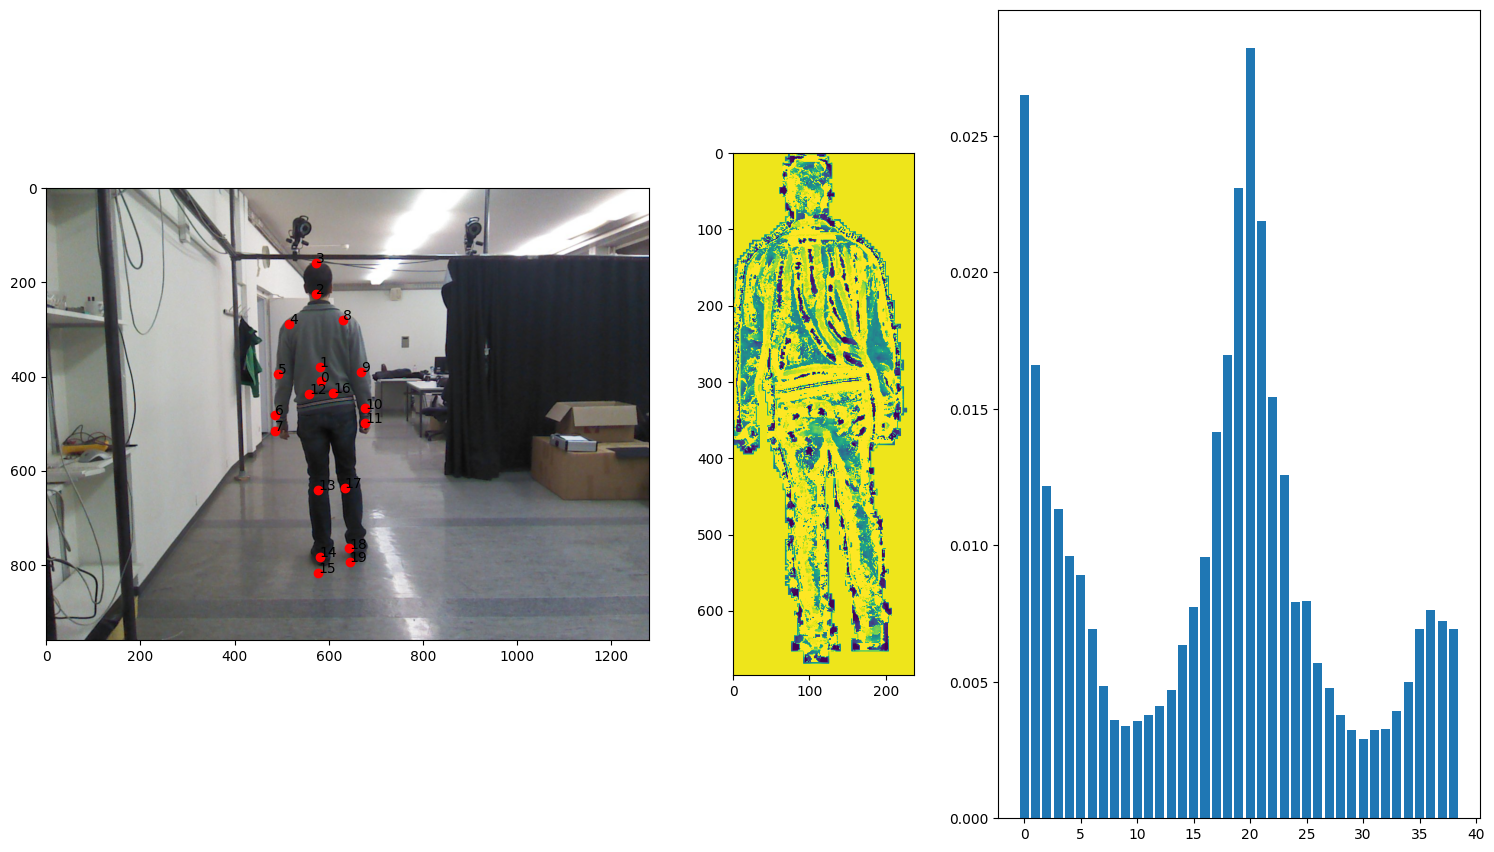

No face detected


In [2]:
d = DataLoader()
d.read_dataset()
d.shuffle_videos()
d.display_dataset()


In [ ]:
import cv2
import random
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import config
import dlib
import time


sample = d.dataset[40][random.randint(0, len(d.dataset[40]))]
frame = d.read_image(sample[0])
face = d.crop_face(frame,d.read_2d_skeleton(sample[3]))[0]
orig = face.copy()

def extract_landmark_features(img):
    # Import the necessary libraries
    
    # Load the pre-trained facial landmark detection model
    predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

    # Load the input image and convert it to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    # Use the predictor to detect the facial landmarks in the grayscale image
    dets = dlib.get_frontal_face_detector()
    

    faces = dets(gray)
    if len(faces) <= 0:
        return None
    points_x = []   
    points_y = []    

    # Loop through the detected faces and extract the landmark features
    shape_np = np.zeros((68, 2), dtype="int")
    for face in faces:
        shape = predictor(gray, face)
        #use the np array?
        for i in range(0, 68):
                shape_np[i] = (shape.part(i).x, shape.part(i).y)
                cv2.circle(img, (shape.part(i).x, shape.part(i).y), 1, (0, 255, 0), -1)
    
    return shape_np

def extract_hog_features(img):
    # Import the necessary libraries
    from skimage.feature import hog
    from skimage import data, exposure

    # Load the input image and convert it to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    # Extract the hog features from the grayscale image
    fd, hog_image = hog(gray, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, multichannel=False)

    # Rescale the output image for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return hog_image_rescaled

def extract_lbp_features(img):
    # Import the necessary libraries
    from skimage.feature import local_binary_pattern

    # Load the input image and convert it to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    # Apply local binary pattern to the grayscale image
    radius = 1
    no_points = 30 * radius
    lbp = local_binary_pattern(gray, no_points, radius, method='uniform')

    return lbp



ld = extract_landmark_features(face)
hog = extract_hog_features(face)
lbp = extract_lbp_features(face)
# haar = extract_haar_features(face)


while(ld is None):
    sample = d.dataset[40][random.randint(0, len(d.dataset[40]))]
    frame = d.read_image(sample[0])
    face = d.crop_face(frame,d.read_2d_skeleton(sample[3]))[0]
    orig = face.copy()
    ld = extract_landmark_features(face)
    hog = extract_hog_features(face)
    lbp = extract_lbp_features(face)
fig, ax = plt.subplots(1, 4,figsize=(15,15))
ax[0].imshow(orig)
ax[1].imshow(face)
ax[2].imshow(hog)
ax[3].imshow(lbp)
#plot the lbp
plt.show()

The next thing to do was to design the learning setting. The first and easiest idea was to test a variety of classifiers, and see which works better for our features.

We tested different classifiers:

In [3]:
X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
X_skel, X_clothes, X_face, _, ___, ____, y_train, _____, y_face, ______ = filter_and_split_dataset(X, y)

X_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_X.npy")
y_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_y.npy")
X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(X_2, y_2)



In [11]:

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

classifiers_skel = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, random_state=2, splitter='random'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=3, p=2, weights='uniform'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_clothes = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, random_state=2, splitter='best'),
    "RandomForestClassifier": RandomForestClassifier(criterion='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 5, n_estimators = 50, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=7, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_face = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=2, splitter='random'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=9, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

fig, ((ax_roc_skel, ax_roc_clothes, ax_roc_face), (ax_det_skel, ax_det_clothes, ax_det_face)) = plt.subplots(2, 3, figsize =(20, 10))
# fig, (ax_roc_skel, ax_roc_clothes, ax_roc_face, ax_det_skel, ax_det_clothes, ax_det_face) = plt.subplots(1, 6, figsize=(50,5))

for name, model in classifiers_skel.items():
    model.fit( PolynomialFeatures().fit_transform(X_skel), y_train)
    RocCurveDisplay.from_estimator(model,  PolynomialFeatures().fit_transform(X_skel_test), y_test, ax=ax_roc_skel, name=name)
    DetCurveDisplay.from_estimator(model,  PolynomialFeatures().fit_transform(X_skel_test), y_test, ax=ax_det_skel, name=name)

for name, model in classifiers_clothes.items():
    model.fit(PolynomialFeatures().fit_transform(X_clothes), y_train)
    RocCurveDisplay.from_estimator(model, PolynomialFeatures().fit_transform(X_clothes_test), y_test, ax=ax_roc_clothes, name=name)
    DetCurveDisplay.from_estimator(model, PolynomialFeatures().fit_transform(X_clothes_test), y_test, ax=ax_det_clothes, name=name)

for name, model in classifiers_face.items():
    model.fit(PolynomialFeatures().fit_transform(X_face), y_face)
    RocCurveDisplay.from_estimator(model, PolynomialFeatures().fit_transform(X_face_test), y_face_test, ax=ax_roc_face, name=name)
    DetCurveDisplay.from_estimator(model, PolynomialFeatures().fit_transform(X_face_test), y_face_test, ax=ax_det_face, name=name)


ax_roc_skel.set_title("Receiver Operating Characteristic (ROC) curves - Skeleton")
ax_det_skel.set_title("Detection Error Tradeoff (DET) curves - Skeleton")
ax_roc_clothes.set_title("Receiver Operating Characteristic (ROC) curves - Clothes")
ax_det_clothes.set_title("Detection Error Tradeoff (DET) curves - Clothes")
ax_roc_face.set_title("Receiver Operating Characteristic (ROC) curves - Face")
ax_det_face.set_title("Detection Error Tradeoff (DET) curves - Face")


ax_roc_skel.grid(linestyle="--")
ax_det_skel.grid(linestyle="--")
ax_roc_clothes.grid(linestyle="--")
ax_det_clothes.grid(linestyle="--")
ax_roc_face.grid(linestyle="--")
ax_det_face.grid(linestyle="--")


plt.legend()
plt.savefig("ROC_DET_curves.png")

## Model Tuning

### Fit and Evaluate Models

Block that contains the code to fit and evaluate the models.

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
# from math import round

class_names = ['Different', 'Same']

def fit_models(models, X_train, y_train):
    for name, model in models.items():
        model.fit(X_train, y_train.ravel())
        print(name, 'trained.')
    return

def evaluate_models(models,model_name,X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred,zero_division=0))
        cv_accuracy = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='accuracy')
        cv_precision = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='precision')
        cv_f1_macro = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='f1_macro')
        print(cross_val_score(model, X_test, y_test, scoring='accuracy'))
        print("Accuracy: %0.4f (+/- %0.4f)" % (cv_accuracy.mean(), cv_accuracy.std() * 2))
        print(cross_val_score(model, X_test, y_test, scoring='precision'))
        print("Precision: %0.4f (+/- %0.4f)" % (cv_precision.mean(), cv_precision.std() * 2))
        print(cross_val_score(model, X_test, y_test, scoring='f1_macro'))
        print("f1-score: %0.4f (+/- %0.4f)" % (cv_f1_macro.mean(), cv_f1_macro.std() * 2))
        if name.count("accuracy") > 0 or name.count("precision") > 0:
            cm = confusion_matrix(y_test, y_pred)
            cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            disp = ConfusionMatrixDisplay(confusion_matrix=cmn, display_labels=class_names)
            disp.plot(cmap=plt.cm.Purples)
            disp.ax_.set_title(name + ' (' + model_name + ')') 
        print('------------------------------------'*3)
        
    return  

### Model Tuning

Block that contains the code to tune the models with the grid search.

In [6]:

def tune_model(model, param_grid, scoring, x_train, y_train, grid_jobs):
    print('tuning...')
    clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, verbose=1, n_jobs=grid_jobs)
    clf.fit(x_train, y_train.ravel())
    print('done')
    print()
    print(f"Best {scoring}: {clf.best_score_} using {clf.best_params_}")
    best_params = clf.best_params_.copy()
    return best_params

### Models

Block with parameters to test for the models.

In [7]:

SVM_param_grid = {
    'C': [1],
    'kernel': ['linear'],
    'degree': [3],
    'gamma': ['auto'],
    'random_state': [42],
    'tol': [1e-3]
}

RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}


Gauss_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

KNN_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]
}

DT_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}

Regres_param_grid = {
    'solver': ['liblinear'],
    'max_iter': [10000]
}

models = {
    "KNN": (KNeighborsClassifier, KNN_param_grid),
    "DT": (DecisionTreeClassifier, DT_param_grid),
    "RF": (RandomForestClassifier, RF_param_grid),
    "GNB": (GaussianNB, Gauss_param_grid),
    "SVM": (SVC, SVM_param_grid),
    "LogReg": (LogisticRegression, Regres_param_grid),
}

### Tuning and Evaluation

In this block we will tune the parameters of the models and evaluate them. 
We searched for those parameters that lower accuracy, precision and f1 (parameters that optimize accuracy may not also optimize precision or f1 and viceversa).
We also plotted the confusion matrix for each model and each best parameter found in order to have a graphical view of performances.

KNN
tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
done

Best: 0.987087 using {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
done

Best: 1.000000 using {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
done

Best: 0.864782 using {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
done

Best: 0.984509 using {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

done

Best: 0.971429 using {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
done

Best: 0.830476 using {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
done

Best: 0.978667 using {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

done

Best: 0.000000 using {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
done

Best: 0.494604 using {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Skeleton accuracy trained.
Skeleton precision trained.
Skeleton f1_macro trained.
Clothes accuracy trained.
Clothes precision trained.
Clothes f1_macro trained.
--------------------------------------------------
Skeleton
Skeleton accuracy
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1125
           1       0.83      0.51      0.63        37

    accuracy                           0.98      1162
   macro avg       0.91      0.75      0.81      1162
weighted avg       0.98      0.98      0.98      1162

[0.99570815 0.97854077 0.98706897 0.96982759 0.98275862]
Accuracy: 0.9828 (+/- 0.0172)
[0.88888889 1.         1.         0.5        

/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

done

Best: 0.960000 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}
tuning...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
done

Best: 0.760473 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'random_state': 2, 'splitter': 'random'}
tuning...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
done

Best: 0.971604 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'random_state': 42, 'splitter': 'random'}
tuning...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

done

Best: 0.686667 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'random_state': 42, 'splitter': 'random'}
tuning...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
done

Best: 0.722335 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 2, 'splitter': 'best'}
tuning...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
done

Best: 0.978667 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 2, 'splitter': 'random'}
tuning...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

done

Best: 0.100000 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
tuning...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
done

Best: 0.543225 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
Skeleton accuracy trained.
Skeleton precision trained.
Skeleton f1_macro trained.
Clothes accuracy trained.
Clothes precision trained.
Clothes f1_macro trained.
--------------------------------------------------
Skeleton
Skeleton accuracy
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1125
           1       0.57      0.43      0.49        37

    accuracy                           0.97      1162
   macro avg       0.78      0.71      0.74      1162
weighted avg       0.97      0.97      0.97      1162

[0.

/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

[0. 0. 1. 0. 1.]
Precision: 0.4000 (+/- 0.9798)
[0.49126638 0.49126638 0.61842105 0.49234136 0.61842105]
f1-score: 0.5423 (+/- 0.1242)
------------------------------------------------------------------------------------------------------------
Skeleton f1_macro
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1125
           1       0.16      0.11      0.13        37

    accuracy                           0.95      1162
   macro avg       0.57      0.54      0.55      1162
weighted avg       0.95      0.95      0.95      1162

[0.97424893 0.95708155 0.97413793 0.9612069  0.96551724]
Accuracy: 0.9664 (+/- 0.0137)
[0.625      0.375      1.         0.33333333 0.        ]
Precision: 0.4667 (+/- 0.6654)
[0.80583333 0.67638889 0.61842105 0.64386833 0.49122807]
f1-score: 0.6471 (+/- 0.2024)
------------------------------------------------------------------------------------------------------------
----------------------------------------

/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

done

Best: 1.000000 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 2}
tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
done

Best: 0.787856 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}
tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
done

Best: 0.977627 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50, 'random_state': 2}
tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

done

Best: 1.000000 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 2}
tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
done

Best: 0.716513 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50, 'random_state': 2}
tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
done

Best: 0.978667 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 2}
tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

done

Best: 0.000000 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 2}
tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
done

Best: 0.494604 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 2}
Skeleton accuracy trained.
Skeleton precision trained.
Skeleton f1_macro trained.
Clothes accuracy trained.
Clothes precision trained.
Clothes f1_macro trained.
--------------------------------------------------
Skeleton
Skeleton accuracy
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1125
           1       1.00      0.49      0.65        37

    accuracy                           0.98      1162
   macro avg       0.99      0.74      0.82      1162
weighted avg       0.98      0.98      0.98      1162

[0.9

/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.96566524 0.96995708 0.98275862 0.96982759 0.97413793]
Accuracy: 0.9725 (+/- 0.0116)


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0. 1. 1. 0. 1.]
Precision: 0.6000 (+/- 0.9798)
[0.49126638 0.60345247 0.79559471 0.49234136 0.61842105]
f1-score: 0.6002 (+/- 0.2227)
------------------------------------------------------------------------------------------------------------
Clothes f1_macro
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1125
           1       1.00      0.24      0.39        37

    accuracy                           0.98      1162
   macro avg       0.99      0.62      0.69      1162
weighted avg       0.98      0.98      0.97      1162

[0.96995708 0.96995708 0.98275862 0.97413793 0.97413793]
Accuracy: 0.9742 (+/- 0.0093)
[1. 1. 1. 1. 1.]
Precision: 1.0000 (+/- 0.0000)
[0.60345247 0.60345247 0.79559471 0.61842105 0.61842105]
f1-score: 0.6479 (+/- 0.1483)
------------------------------------------------------------------------------------------------------------
--------------------------------------------------
Face
-------------------------

/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

Skeleton accuracy trained.
Skeleton precision trained.
Skeleton f1_macro trained.
Clothes accuracy trained.
Clothes precision trained.
Clothes f1_macro trained.
--------------------------------------------------
Skeleton
Skeleton accuracy
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162

[0.90128755 0.87124464 0.87931034 0.81034483 0.96982759]
Accuracy: 0.8864 (+/- 0.1029)
[0.24137931 0.13333333 0.11111111 0.04878049 0.5       ]
Precision: 0.2069 (+/- 0.3184)
[0.66238266 0.57021643 0.55567715 0.48878205 0.7230087 ]
f1-score: 0.6000 (+/- 0.1655)
------------------------------------------------------------------------------------------------------------
Skeleton precision
              precision    recall  f1-score 

/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

done

Best: 0.000000 using {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'random_state': 42, 'tol': 0.001}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.491911 using {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'random_state': 42, 'tol': 0.001}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.968163 using {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'random_state': 42, 'tol': 0.001}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.000000 using {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'random_state': 42, 'tol': 0.001}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.491911 using {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'random_state': 42, 'tol': 0.001}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.976000 using {'C': 1, 'degree': 3, 'gamma

/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

Skeleton accuracy trained.
Skeleton precision trained.
Skeleton f1_macro trained.
Clothes accuracy trained.
Clothes precision trained.
Clothes f1_macro trained.
--------------------------------------------------
Skeleton
Skeleton accuracy
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162



/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

[0.96566524 0.96566524 0.96982759 0.96982759 0.96982759]
Accuracy: 0.9682 (+/- 0.0041)


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49126638 0.49234136 0.49234136 0.49234136]
f1-score: 0.4919 (+/- 0.0011)
------------------------------------------------------------------------------------------------------------
Skeleton precision
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162



/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

[0.96566524 0.96566524 0.96982759 0.96982759 0.96982759]
Accuracy: 0.9682 (+/- 0.0041)


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49126638 0.49234136 0.49234136 0.49234136]
f1-score: 0.4919 (+/- 0.0011)
------------------------------------------------------------------------------------------------------------
Skeleton f1_macro
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162



/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

[0.96566524 0.96566524 0.96982759 0.96982759 0.96982759]
Accuracy: 0.9682 (+/- 0.0041)


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49126638 0.49234136 0.49234136 0.49234136]
f1-score: 0.4919 (+/- 0.0011)
------------------------------------------------------------------------------------------------------------
--------------------------------------------------
Clothes
--------------------------------------------------
Clothes accuracy
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162

[0.96566524 0.96566524 0.96982759 0.96982759 0.96982759]
Accuracy: 0.9682 (+/- 0.0041)
[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49126638 0.49234136 0.49234136 0.49234136]
f1-score: 0.4919 (+/- 0.0011)


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

------------------------------------------------------------------------------------------------------------
Clothes precision
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162

[0.96566524 0.96566524 0.96982759 0.96982759 0.96982759]
Accuracy: 0.9682 (+/- 0.0041)
[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49126638 0.49234136 0.49234136 0.49234136]
f1-score: 0.4919 (+/- 0.0011)


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

------------------------------------------------------------------------------------------------------------
Clothes f1_macro
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162

[0.96566524 0.96566524 0.96982759 0.96982759 0.96982759]
Accuracy: 0.9682 (+/- 0.0041)
[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49126638 0.49234136 0.49234136 0.49234136]
f1-score: 0.4919 (+/- 0.0011)
------------------------------------------------------------------------------------------------------------
--------------------------------------------------
Face
--------------------------------------------------
LogReg
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.966439 using {'max_

/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.000000 using {'max_iter': 10000, 'solver': 'liblinear'}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.491465 using {'max_iter': 10000, 'solver': 'liblinear'}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.968163 using {'max_iter': 10000, 'solver': 'liblinear'}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.000000 using {'max_iter': 10000, 'solver': 'liblinear'}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.491911 using {'max_iter': 10000, 'solver': 'liblinear'}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.978667 using {'max_iter': 10000, 'solver': 'liblinear'}
tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done

Best: 0.300000 using {'max_iter': 10000, 'solver': 'liblinear'}
tuning...
Fitting 5 folds for each of

/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

done

Best: 0.611243 using {'max_iter': 10000, 'solver': 'liblinear'}
Skeleton accuracy trained.
Skeleton precision trained.
Skeleton f1_macro trained.
Clothes accuracy trained.
Clothes precision trained.
Clothes f1_macro trained.
--------------------------------------------------
Skeleton
Skeleton accuracy
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162

[0.96566524 0.96137339 0.9612069  0.9612069  0.9612069 ]
Accuracy: 0.9621 (+/- 0.0035)


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49015317 0.49010989 0.49010989 0.49010989]
f1-score: 0.4903 (+/- 0.0009)
------------------------------------------------------------------------------------------------------------
Skeleton precision
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162



/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.96566524 0.96137339 0.9612069  0.9612069  0.9612069 ]
Accuracy: 0.9621 (+/- 0.0035)
[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49015317 0.49010989 0.49010989 0.49010989]
f1-score: 0.4903 (+/- 0.0009)
------------------------------------------------------------------------------------------------------------
Skeleton f1_macro
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162



/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.96566524 0.96137339 0.9612069  0.9612069  0.9612069 ]
Accuracy: 0.9621 (+/- 0.0035)
[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49015317 0.49010989 0.49010989 0.49010989]
f1-score: 0.4903 (+/- 0.0009)
------------------------------------------------------------------------------------------------------------
--------------------------------------------------
Clothes
--------------------------------------------------
Clothes accuracy
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162



/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

[0.96566524 0.96566524 0.96982759 0.96982759 0.96982759]
Accuracy: 0.9682 (+/- 0.0041)
[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49126638 0.49234136 0.49234136 0.49234136]
f1-score: 0.4919 (+/- 0.0011)
------------------------------------------------------------------------------------------------------------
Clothes precision
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162



/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

[0.96566524 0.96566524 0.96982759 0.96982759 0.96982759]
Accuracy: 0.9682 (+/- 0.0041)
[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49126638 0.49234136 0.49234136 0.49234136]
f1-score: 0.4919 (+/- 0.0011)


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------------------------------------------------------------------------------------------
Clothes f1_macro
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1125
           1       0.00      0.00      0.00        37

    accuracy                           0.97      1162
   macro avg       0.48      0.50      0.49      1162
weighted avg       0.94      0.97      0.95      1162



/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs

[0.96566524 0.96566524 0.96982759 0.96982759 0.96982759]
Accuracy: 0.9682 (+/- 0.0041)


/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/miniconda3/envs/DroneCollision/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0. 0. 0. 0. 0.]
Precision: 0.0000 (+/- 0.0000)
[0.49126638 0.49126638 0.49234136 0.49234136 0.49234136]
f1-score: 0.4919 (+/- 0.0011)
------------------------------------------------------------------------------------------------------------
--------------------------------------------------
Face
--------------------------------------------------


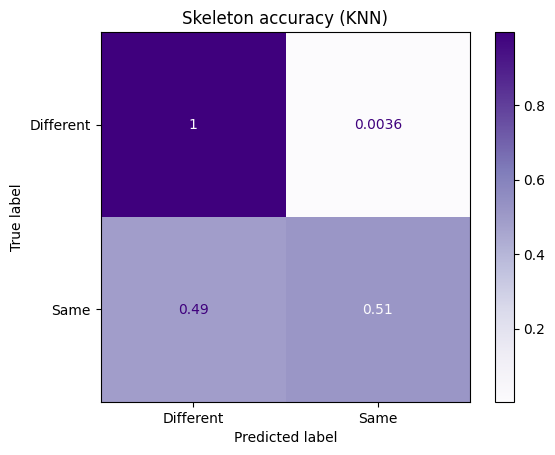

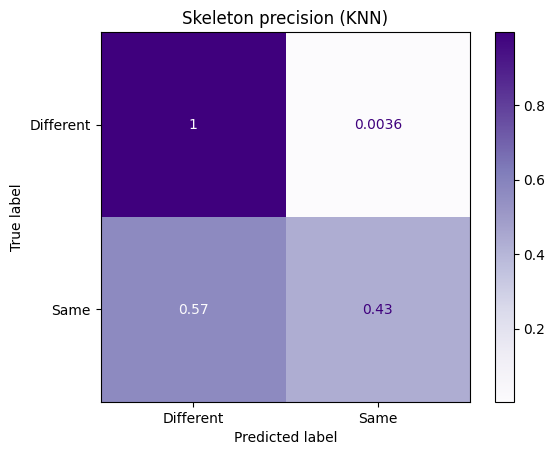

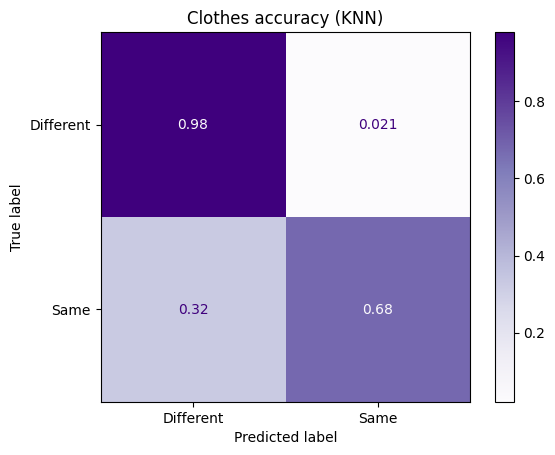

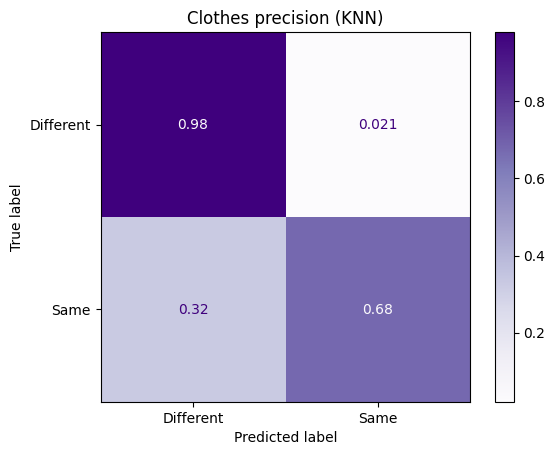

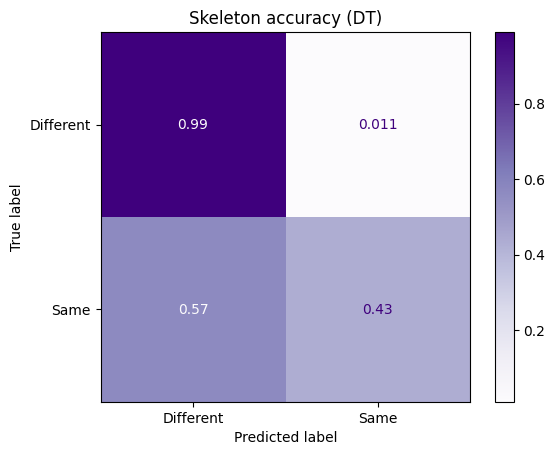

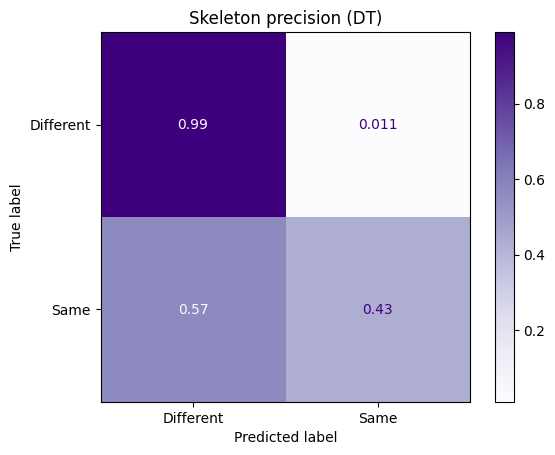

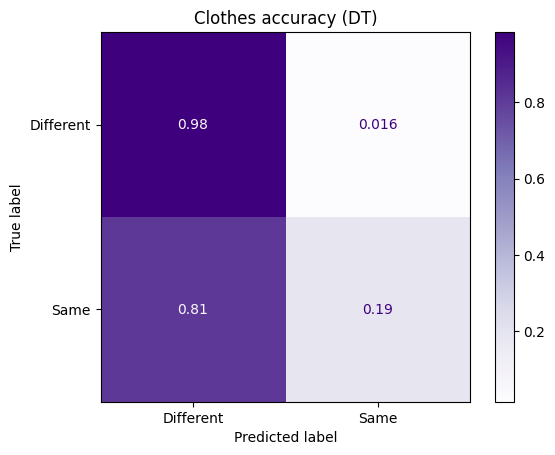

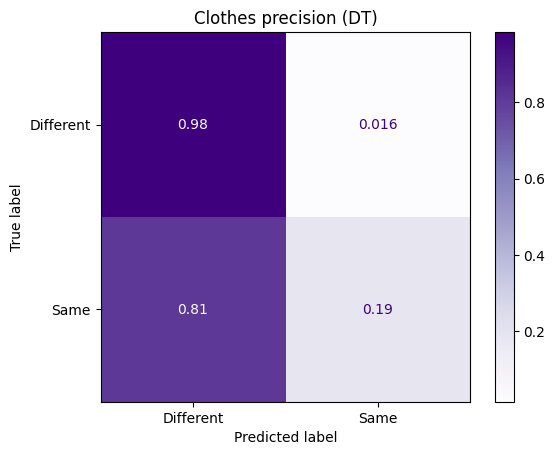

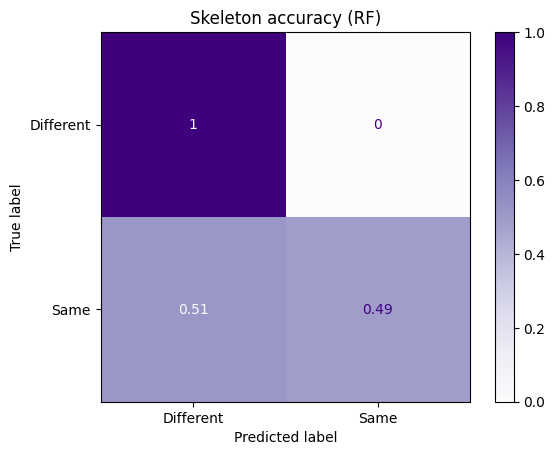

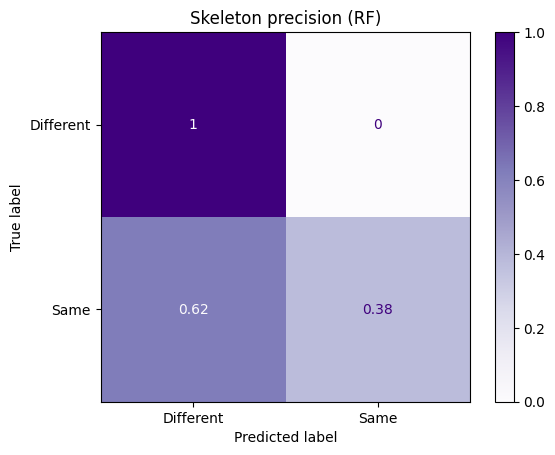

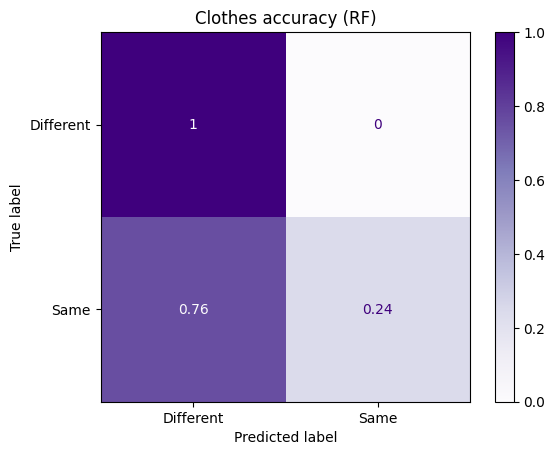

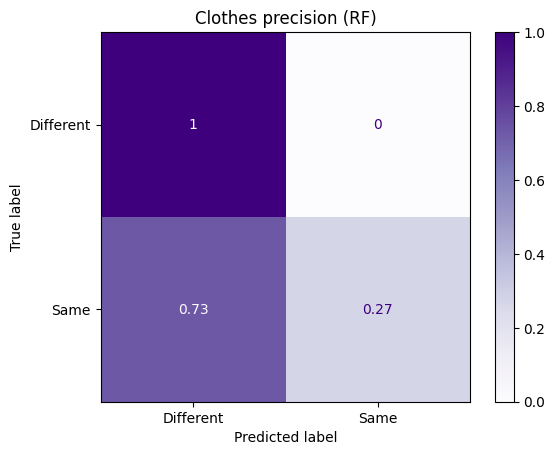

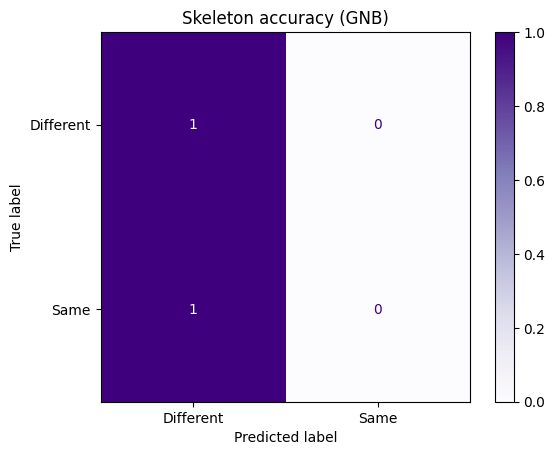

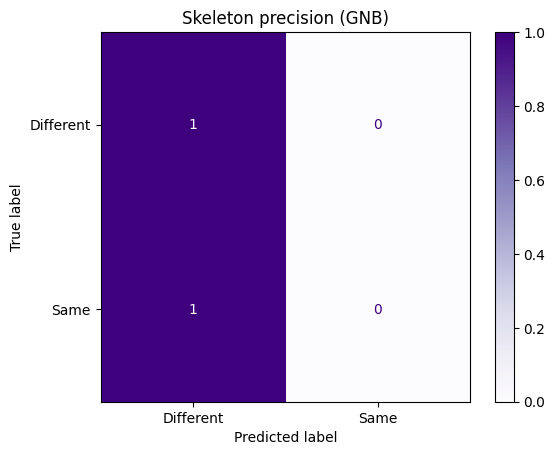

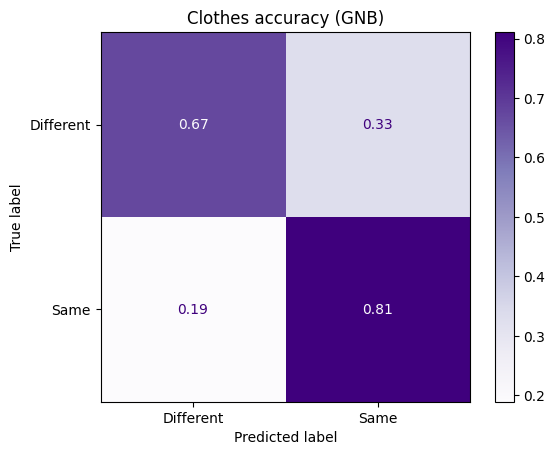

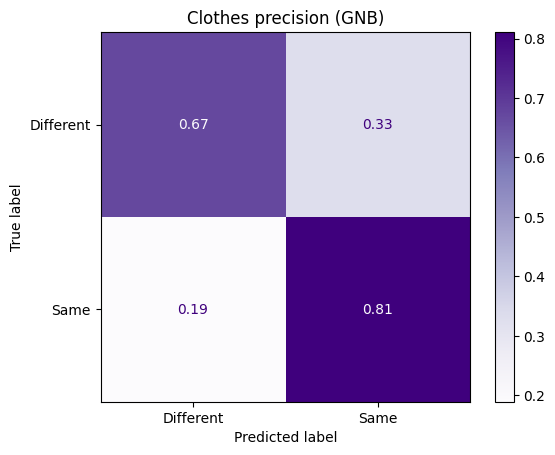

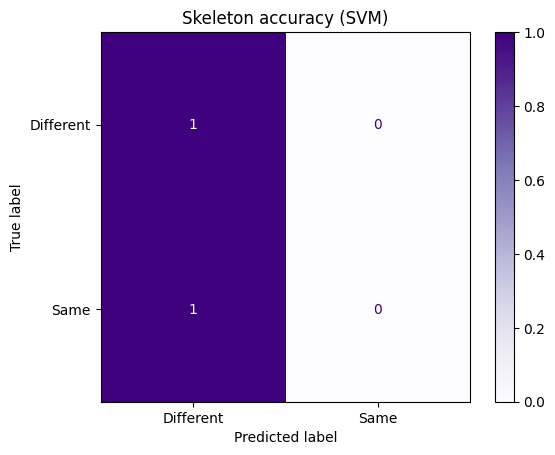

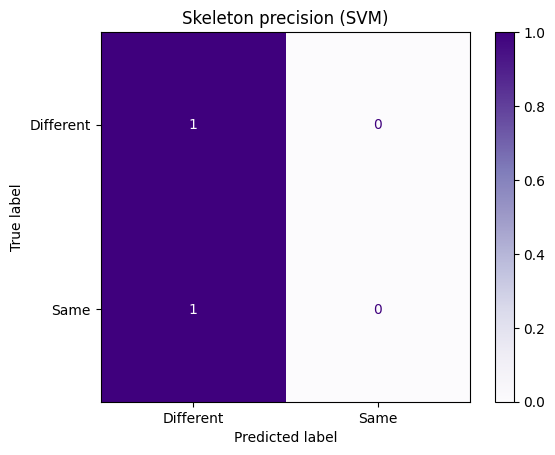

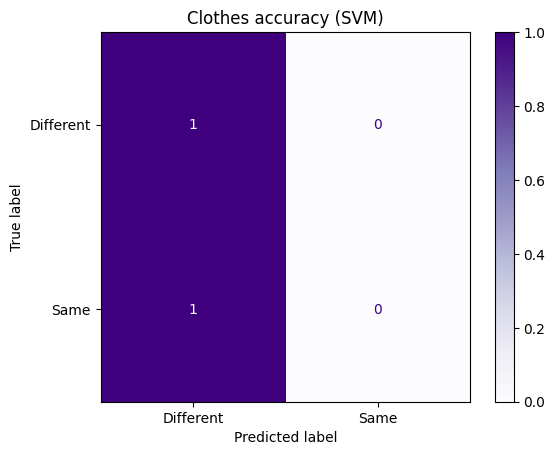

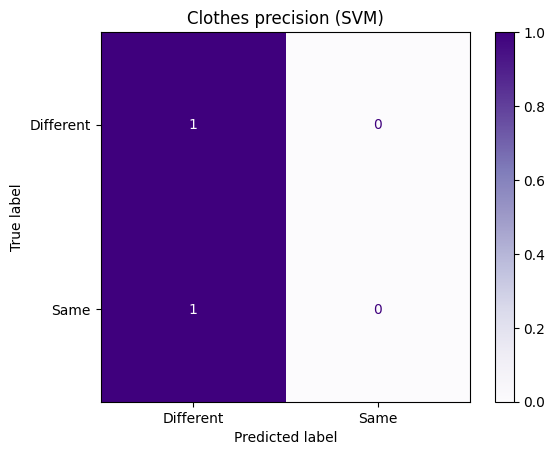

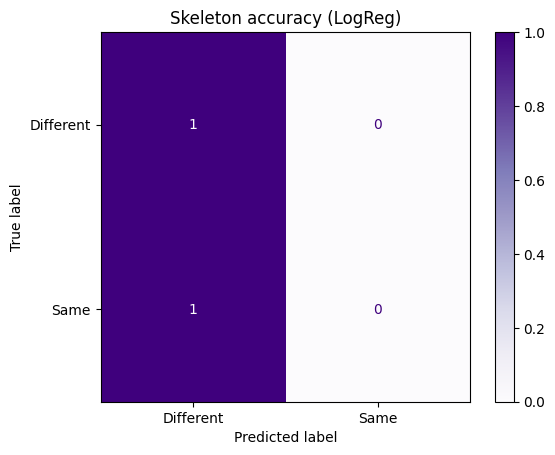

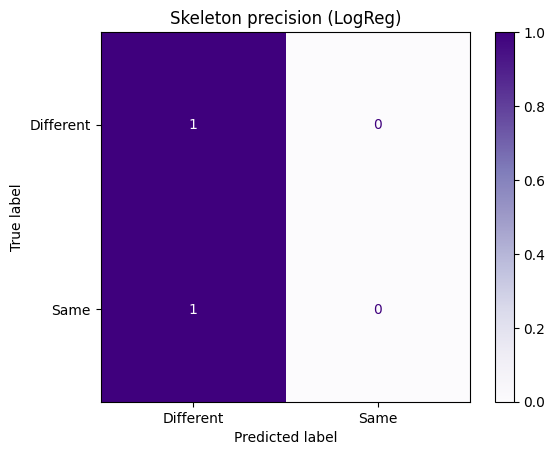

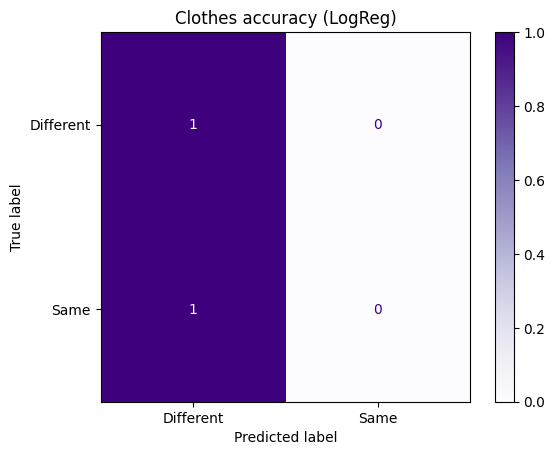

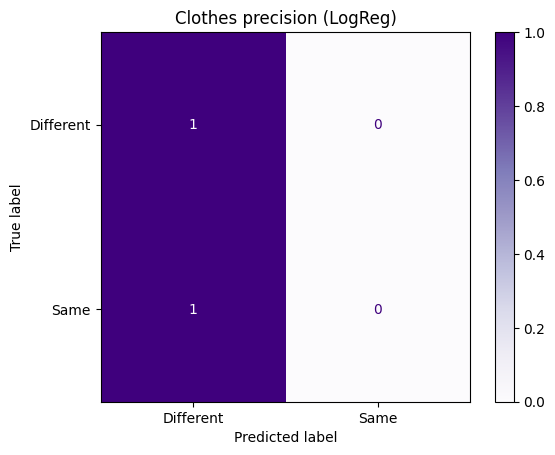

In [9]:

for model in models:
    print(model)
    current_model = models[model]
    best_accuracy_params_skel = tune_model(current_model[0](), current_model[1], 'accuracy', X_skel, y_train, -1)
    best_precision_params_skel = tune_model(current_model[0](), current_model[1], 'precision', X_skel, y_train, -1)
    best_f1macro_params_skel = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_skel, y_train, -1)
    best_accuracy_params_clothes = tune_model(current_model[0](), current_model[1], 'accuracy', X_clothes, y_train, -1)
    best_precision_params_clothes = tune_model(current_model[0](), current_model[1], 'precision', X_clothes, y_train, -1)
    best_f1macro_params_clothes = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_clothes, y_train, -1)
    best_accuracy_params_face = tune_model(current_model[0](), current_model[1], 'accuracy', X_face, y_face, -1)
    best_precision_params_face = tune_model(current_model[0](), current_model[1], 'precision', X_face, y_face, -1)
    best_f1macro_params_face = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_face, y_face, -1)
    tuned_models_skel = {
        'Skeleton accuracy': current_model[0](**best_accuracy_params_skel),
        'Skeleton precision': current_model[0](**best_precision_params_skel),
        'Skeleton f1_macro': current_model[0](**best_f1macro_params_skel)
    }

    tuned_models_clothes = {
        'Clothes accuracy': current_model[0](**best_accuracy_params_clothes),
        'Clothes precision': current_model[0](**best_precision_params_clothes),
        'Clothes f1_macro': current_model[0](**best_f1macro_params_clothes)
    }

    tuned_models_face = {
        'Face accuracy': current_model[0](**best_accuracy_params_face),
        'Face precision': current_model[0](**best_precision_params_face),
        'Face f1_macro': current_model[0](**best_f1macro_params_face)
    }
        
    fit_models(tuned_models_skel, X_skel, y_train)
    fit_models(tuned_models_clothes, X_clothes, y_train)
    fit_models(tuned_models_face, X_face, y_face)
    print("-"*50)
    print("Skeleton")
    evaluate_models(tuned_models_skel,model, X_skel_test, y_test)
    print("-"*50)
    print("Clothes")
    print("-"*50)
    evaluate_models(tuned_models_clothes,model, X_clothes_test, y_test)
    print("-"*50)
    print("Face")
    print("-"*50)
    evaluate_models(tuned_models_face,model, X_face_test, y_face_test)


### Results
| Model | Skeleton | Clothes | Face | 
| :--- | :---: | :---: | :---: | 
| DT | 0.91 | 0.93  | 0.81 |
| RF | 0.93 | 0.94  | 0.85 |
| SVC | 0.91 | 0.93  | 0.81 |
| GNB | 0.89 | 0.79  | 0.81 |
| KNN | 0.94 | 0.94  | 0.84 |

In [ ]:
# Train the models on the big dataset

X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test = filter_and_split_dataset(X, y)

model_skel = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=7, p=1, weights='distance')  #  RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42)
model_clothes = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=5, p=1, weights='distance')  # RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100, random_state = 42)
model_face = SVC(C = 1, kernel = "poly", degree = 3, gamma = "auto", probability = True, random_state = 2)


model_skel.fit(X_skel, y_train)
model_clothes.fit(X_clothes, y_train)
# model_face.fit(X_face, y_face)

# Sample dataset live

X, y, images = d.sample_dataset(video=0, return_images=True, seed=10)
X_train, _, y_train, __, images_train, ___ = train_test_split(X, y, images, stratify=y)
print(y_train)

print("-" * 10)
print("skel")
skel_pred = model_skel.predict(X_train[:, : 9])
print(skel_pred)
print(classification_report(y_train, skel_pred))
print("-" * 10)
print("clothes")
clothes_pred = model_clothes.predict(X_train[:, 9 : 9 + config.NUM_POINTS_LBP])
print(clothes_pred)
print(classification_report(y_train, clothes_pred))
print("-" * 10)


# print("face")
# X_face = []
# y_face = []

# for i in range(len(X_train)):
#     if not math.isnan(X_train[i][0]):
#         X_face.append(X_train[i])
#         y_face.append(y_train[i])
        
# face_pred = model_face.predict(X_face)
# print(classification_report(y_face, face_pred))



target = np.where(y_train == 1)
target_img = images_train[target[0][0]]

fig, ax = plt.subplots(len(y_train) // 5 + 1, 5)
fig.set_size_inches(18.5, 10.5)

for i in range(len(y_train)):
    t, el = y_train[i], images_train[i]
    ax[i // 5, i % 5].imshow(el)
plt.show()
 

for idx in range(len(y_train)):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax[0].imshow(images_train[idx])
    ax[0].set_title(f"True label: {y_train[idx]}, predict: {bool(skel_pred[idx] or clothes_pred[idx])}")
    ax[1].imshow(target_img)
    ax[1].set_title("Target")#"skel label: " + str(bool(res[1][0])), "clothes label: " + str(bool(res[1][1])), "face label: " + str(bool(res[1][2])))
    print(skel_pred[idx], clothes_pred[idx])
    plt.show()

## Regression

We also thought that it was possible to learn a "latent space" that ensambles that person's features. The idea is that a regressor can learn how to optimize the outpot of a linear combination so that features from the person that we want to re-identify will output a low value (0) while the other people will output an higher value (1).

Given that, we tested some regressors in order to learn the features of a person.

In [91]:
# X_logistic, y_logistc, _ = d.sample_dataset(video=0, return_images=False)
X = np.load(config.SAMPLED_PATH + "video_3_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_3_sample_0_y.npy")
y -= 1
y *= -1
X_skel, X_clothes, X_face, trhs_skel, trhs_clothes, trhs_faces, y_train, y_trhs, y_face, y_trhs_face = filter_and_split_dataset(X, y)

X_2 = np.load(config.SAMPLED_PATH + "video_3_sample_1_X.npy")
y_2 = np.load(config.SAMPLED_PATH + "video_3_sample_1_y.npy")
y_2 -= 1
y_2 *= -1
X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(X_2, y_2)
    
def test_model_(name, model, X_train, X_test, y_train, y_test, ax_scatter, ax_reg):
    # fit the model on the training set
    model.fit(X_train, y_train)
    # Test
    print("-" * 10)
    print("|", name, "|")
    print("-" * 10)
    pred = model.predict(X_test)
    
    
    # Plots
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_train)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

    # plt.figure(figsize=(10,6))
    ax_scatter.scatter(
        pca_result[:, 0], pca_result[:, 1],
        c=y_train,
        cmap='prism',
        alpha=0.5
    )
    ax_scatter.set_xlabel('Principal Component 1')
    ax_scatter.set_ylabel('Principal Component 2')
    
    # plt.show()

    # tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
    # tsne_results = tsne.fit_transform(X_train, y=y_train)

    # plt.figure(figsize=(10,6))
    # plt.scatter(
    #     tsne_results[:, 0], tsne_results[:, 1],
    #     c=y_train,
    #     cmap='prism'
    # )
    # plt.xlabel('t-SNE Component 1')
    # plt.ylabel('t-SNE Component 2')
    # plt.show()
    
    print(mean_absolute_error(y_test, pred))
    print(mean_squared_error(y_test, pred))
    ax_reg.plot(y_test, pred, 'o')    


----------
| Skel |
----------
Explained variation per principal component: [0.81601658 0.06845523]
0.08278172680002965
0.028581720046386205
----------
| Clothes |
----------
Explained variation per principal component: [0.75471521 0.22846105]
0.07655115509630805
0.015935684324803735
----------
| Face |
----------
Explained variation per principal component: [0.80406759 0.08247186]
0.07039391649285826
0.02516197000049658


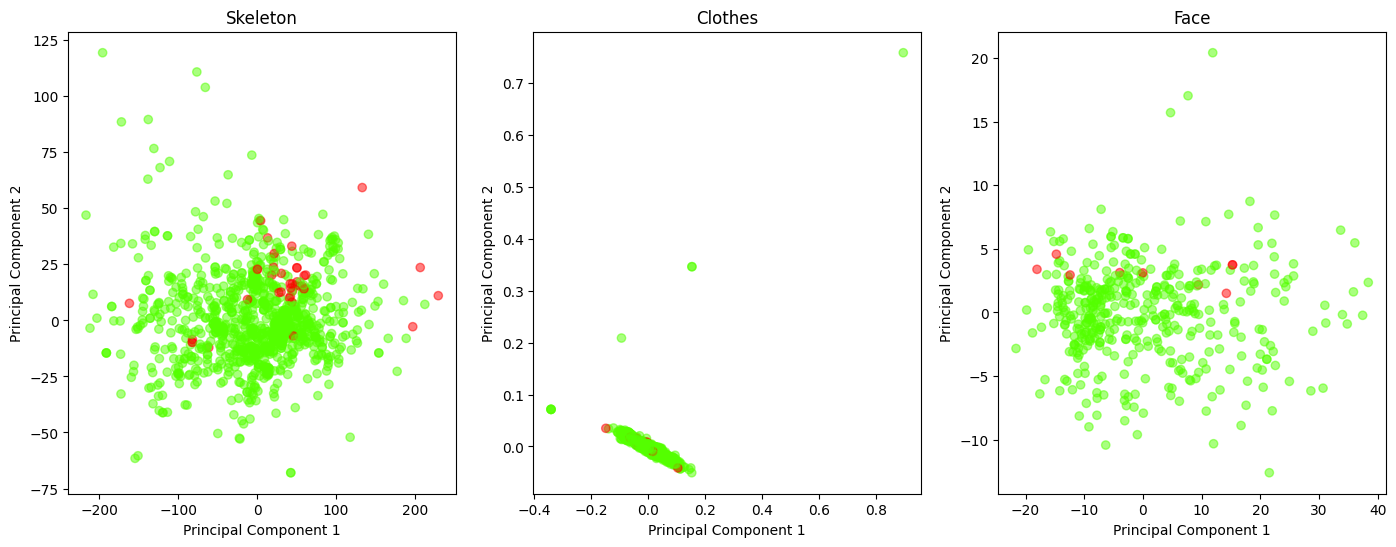

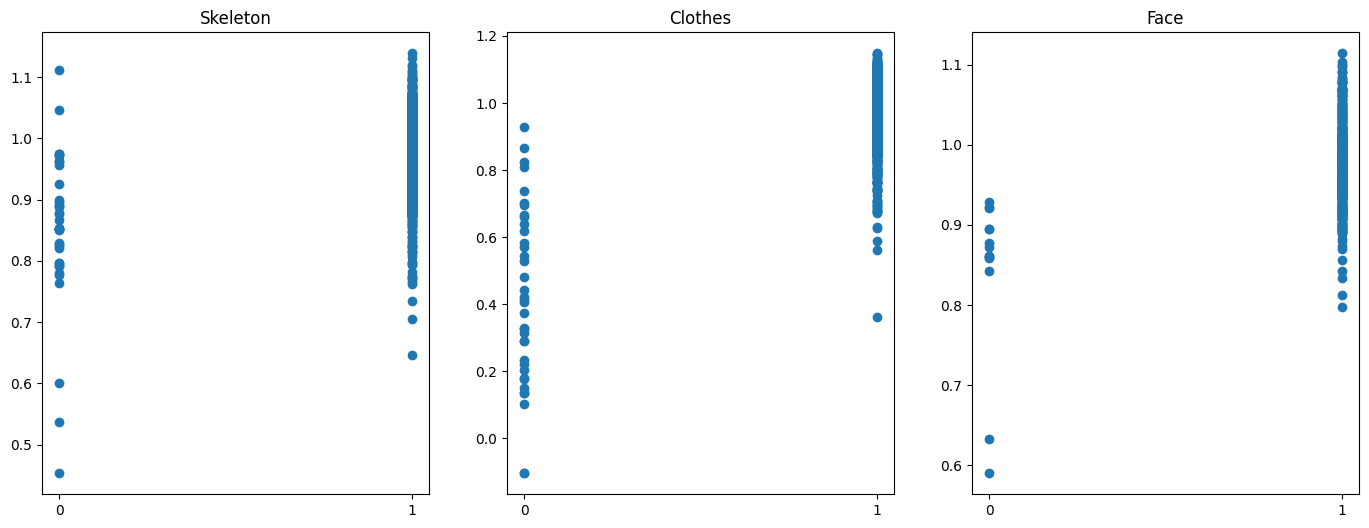

In [95]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeRegressor
    
m1 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("SVRLogistic", SVR())])
m2 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("SVRLogistic", SVR())])
m3 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("SVRLogistic", SVR())])

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(17, 6)
ax[0].set_title("Skeleton")
ax[1].set_title("Clothes")
ax[2].set_title("Face")

fig_reg, ax_reg = plt.subplots(1, 3)
fig_reg.set_size_inches(17, 6)
ax_reg[0].set_xticks(range(0, 2))
ax_reg[0].set_title("Skeleton")
ax_reg[1].set_xticks(range(0, 2))
ax_reg[1].set_title("Clothes")
ax_reg[2].set_xticks(range(0, 2))
ax_reg[2].set_title("Face")


test_model_("Skel", m1, X_skel, X_skel_test, y_train, y_test, ax[0], ax_reg[0])
test_model_("Clothes", m2, X_clothes, X_clothes_test, y_train, y_test, ax[1], ax_reg[1])
test_model_("Face", m3, X_face, X_face_test, y_face, y_face_test, ax[2], ax_reg[2])